## Objective

There are many ways to skin a cat, so there isn’t one ‘silver bullit’
solution to the Ames Housing case. This notebook provides possible
solutions with the following in mind:

- Solutions how to do the various steps of the data mining process in clean and compact code, using `sklearn` and `pandas` as much as possible
- KISS principle: see how we can build the best prediction with the least amount of variables
- Demonstrate working in pipelines with pandas (using method chaining and `.pipe`) and `sklearn.pipeline`

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import vegafusion as vf
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.utils import estimator_html_repr
from xgboost import XGBRegressor

# check versions
for library in [alt, pd, sklearn, vf]:
    print(f"using {library.__name__} version {library.__version__}")

# Using Altair for data visualization
# enable VegaFusion to generate plots with more than 5,000 records
vf.enable()

# setting to visualize sklearn pipelines
# see https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f
sklearn.set_config(display="diagram")

# dataset
URL = "https://github.com/eaisi/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true"

# leaderboard to compare our results
LEADERBOARD = "https://github.com/eaisi/discover-projects/blob/main/ames-housing/house-prices-advanced-regression-techniques-publicleaderboard.csv?raw=true"

# fill-value for missings in categorical variables
MISSING = "missing"
NONE = "not present"

using altair version 5.2.0
using pandas version 2.1.4
using sklearn version 1.3.2
using vegafusion version 1.5.1


## Data understanding & preparation

### Results from exploratory data analysis (EDA)

For an elaborate EDA, please refer to [Pedro Marcelino’s notebook on Kaggle](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python). We will cut the chase and just follow-up on the recommendations by the author of the dataset:

- Remove all homes with a living area (GR LIV AREA) above 4000 square feet
- NAs means ‘not presents’ for the categorical variables `Alley`, `Bsmt Qual`, `Bsmt Cond`, `BsmtFin Type 1`, `BsmtFin Type 2`, `Fireplace Qu`, `Garage Type`, `Garage Finish`, `Garage Qual`, `GarageCond`, `Pool QC` `Fence`, `Garage Yr Blt` and `Misc Feature`

Missing values are imputed using a simple imputation strategy. We remove columns that have more than 20% missing values. For 

Besides that, to demonstrate how to use method chaining to build pipelines in pandas we will:

- standardize column names to enable easy dotted access with `df.column_name_no_space`
- optimize memory usage by converting string columns to categorical, and downcasting numeric columns. Use `df.info()` to get a first view. In this case the dataset is not so large (1.8 MB). If anything gets beyond hundreds of MBs in memory, it helps to optimize, by using [`pd.to_numeric(downcast=...)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html?highlight=to_numeric#pandas.to_numeric) and converting categorical variables to [`pd.categorical`](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html). Doing so reduces the memory to 22% of the orginal (400 KB).

In [2]:
def standardize_column_names(s):
    return s.replace(" ", "")


def na_means_none(df):
    cols_na_means_none = [
        "Alley",
        "BsmtQual",
        "BsmtCond",
        "BsmtFinType1",
        "BsmtFinType2",
        "FireplaceQu",
        "GarageType",
        "GarageFinish",
        "GarageQual",
        "GarageCond",
        "PoolQC",
        "Fence",
        "MiscFeature",
    ]

    df.loc[:, cols_na_means_none] = df.loc[:, cols_na_means_none].fillna(value=NONE)
    return df


def optimize_memory(df):
    # objects to categorical
    df[df.select_dtypes(include="object").columns] = df.select_dtypes(
        include="object"
    ).astype("category")

    # convert integers to smallest unsigned integer and floats to smallest
    for old, new in [("integer", "unsigned"), ("float", "float")]:
        for col in df.select_dtypes(include=old).columns:
            df[col] = pd.to_numeric(df[col], downcast=new)

    return df


df = (
    pd.read_csv(URL)
    .rename(columns=standardize_column_names)
    .pipe(na_means_none)
    .pipe(optimize_memory)
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Order          2930 non-null   uint16  
 1   PID            2930 non-null   uint32  
 2   MSSubClass     2930 non-null   uint8   
 3   MSZoning       2930 non-null   category
 4   LotFrontage    2440 non-null   float32 
 5   LotArea        2930 non-null   uint32  
 6   Street         2930 non-null   category
 7   Alley          2930 non-null   category
 8   LotShape       2930 non-null   category
 9   LandContour    2930 non-null   category
 10  Utilities      2930 non-null   category
 11  LotConfig      2930 non-null   category
 12  LandSlope      2930 non-null   category
 13  Neighborhood   2930 non-null   category
 14  Condition1     2930 non-null   category
 15  Condition2     2930 non-null   category
 16  BldgType       2930 non-null   category
 17  HouseStyle     2930 non-null   ca

In [3]:
# check NA means none replacemens
df.Alley.value_counts()

Alley
not present    2732
Grvl            120
Pave             78
Name: count, dtype: int64

In [4]:
# check outliers Gr Liv Area > 4000
alt.Chart(df).mark_point().encode(
    x="SalePrice", y="GrLivArea", tooltip=["GrLivArea", "SalePrice"]
)

alt.Chart(...)

In [5]:
df_no_outliers = df.query("GrLivArea < 4000")
df_no_outliers.shape

(2925, 82)

In [6]:
# see which columns have NAs, you could make this into a small utility function
def na_per_columns(df):
    """Calculates nulls per column"""
    nulls = df.isnull().sum()
    return nulls[nulls != 0].sort_values(ascending=False)


cols_with_nulls = na_per_columns(df)
cols_with_nulls

MasVnrType      1775
LotFrontage      490
GarageYrBlt      159
BsmtExposure      83
MasVnrArea        23
BsmtFullBath       2
BsmtHalfBath       2
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
GarageCars         1
GarageArea         1
dtype: int64

In [7]:
# evaluate which columns have large percentage missing values, say 20%
cols_to_drop = (cols_with_nulls[cols_with_nulls / len(df) > 0.2] / len(df)).index
cols_with_nulls[cols_to_drop]

MasVnrType    1775
dtype: int64

In [8]:
# no data snooping
df_train, df_test = train_test_split(df_no_outliers, test_size=0.3)

### Data preparation

So we are going to:

-   Create different regression models for the logarithm of the
    `SalePrice`
-   Drop columns with more than 20% missing values
-   Impute missing values using
    [`sklearn.impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)
    -   ‘median’ for numerical features
    -   fill with ‘missing’ for categorical features
-   use
    [`OneHotEncoding`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)
    for all categorical variables
-   use
    [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
    on numerical variables just to be sure.

We are going to use
[`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
for our whole workflow. It is good practice to structure your ML project
into separate pipelines for each model. This also allows for stacking
models, as is explained in [this example by Guillaume Lemaitre in the
sklearn
documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py).

### Selecting columns by [`dtype`](https://numpy.org/doc/stable/reference/arrays.scalars.html) with [`df.select_dtypes`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html?highlight=select_dtype)

In [9]:
# prepare X and y, using log(SalePrice) throughout
X = df_train[df_train.columns.difference(cols_to_drop).drop("SalePrice")]
y = np.log(df_train.SalePrice)

# same for test set
X_test = df_test[df_test.columns.difference(cols_to_drop).drop("SalePrice")]
y_test = np.log(df_test.SalePrice)

# read https://numpy.org/doc/stable/reference/arrays.scalars.html
# for understanding NumPy dtype hierarchy
cat_cols = X.select_dtypes(include="category").columns
num_cols = X.select_dtypes(include="number").columns

### Making a pipeline

If you want to read more about pipelines, see [this blogpost by Ankit
Goel](https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f).

If you have used `category` dtypes from the start, you can access the
categories of each categorical column with
[`pd.Series.cat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.html?highlight=cat#pandas.Series.cat).

In [10]:
# need to explicitly define categories for pipeline and add MISSING category
categories = [df[col].cat.categories.to_list() for col in cat_cols]
for cat in categories:
    cat.append(MISSING)

# combine all preprocessing for cat_cols in one pipeline
preprocess_cat_cols = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=MISSING),
    OneHotEncoder(categories=categories),
)

# same for num_cols
preprocess_num_cols = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="median"), StandardScaler()
)

# compose dataset with make_column_transformer
prepare_linear = make_column_transformer(
    (preprocess_num_cols, num_cols), (preprocess_cat_cols, cat_cols), remainder="drop"
)

## Linear models

### [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [11]:
ols = make_pipeline(prepare_linear, LinearRegression())
ols

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath...
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MiscFeature', 'Neighborhood', 'PavedDrive',
       'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType',
       'Street', 'Utilities'],
      dtype='object'))])),
                ('linearregression', LinearRegression())])

In [12]:
ols_scores = cross_validate(
    ols,
    X,
    y,
    cv=10,
    scoring=["neg_mean_squared_error"],
    return_train_score=True,
    return_estimator=True,
)

In [13]:
def plot_cv_scores(df):
    """Plots cv scores using Altair.

    df: dataframe with columns ['train_mean_error', 'train_test_error']

    Returns: alt.Chart
    """

    return (
        alt.Chart(df)
        .mark_point()
        .transform_calculate(
            train_mean_error="sqrt(-datum.train_neg_mean_squared_error)",
            test_mean_error="sqrt(-datum.test_neg_mean_squared_error)",
        )
        .encode(
            x=alt.X("train_mean_error:Q").scale(zero=False),
            y=alt.Y("test_mean_error:Q").scale(zero=False),
            tooltip=[
                alt.Tooltip("train_mean_error:Q", format=".3"),
                alt.Tooltip("test_mean_error:Q", format=".3"),
            ],
        )
    )


plot_cv_scores(pd.DataFrame(ols_scores).drop(columns="estimator"))

alt.Chart(...)

We can conclude from this that we need more work: a low RMSLE on the
training set results in the highest RMSLE for the validation set (and
vice versa). This means we are overfitting. The best model for now is in
the bottom right corner, with the RMSLE around 0.08. Let’s check which
estimator that is and do final scoring on test set.

In [14]:
def get_best_model(cv_scores):
    """
    Return best (most conservative) model from cross_validate object.

    Uses np.argmax to find bottomright point == largest RMLSE
    """
    index = np.argmax(np.sqrt(-cv_scores["train_neg_mean_squared_error"]))
    model = cv_scores["estimator"][index]
    rmsle = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return (model, rmsle)


ols_best_model, ols_rmsle = get_best_model(ols_scores)
print(f"Best OLS model:\n  RMLSE test: {ols_rmsle:0.5f}")

Best OLS model:
  RMLSE test: 0.13043


Not bad: a simple regression model, with preparing the data just as the
author instructed yields a RMSLE of around 0.13. Let’s see where that
gets us on the leaderboard.

In [15]:
leaderboard = pd.read_csv(LEADERBOARD).sort_values("Score").reset_index()
leaderboard.Score.searchsorted(ols_rmsle)

1680

Not bad, given there are more than 5,000 entries.

### More detailed look at linear model

The author of the dataset states that it is easiest to build an
estimator only for houses with `Sale Condition == 'Normal'`. Let’s check
what the distribution of house prices is per `Sale Condition`.

In [16]:
df.SaleCondition.value_counts()

SaleCondition
Normal     2413
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: count, dtype: int64

In [17]:
alt.Chart(df).mark_bar().encode(
    alt.X("SalePrice:Q").bin(),
    alt.Y("count()").scale(type="log"),
    color="SaleCondition:N",
)

alt.Chart(...)

From this we conclude that the distribution of the `log(SalePrice)` is
quite different depending on `Sale Condition`. This probably explains
why our performance with a simple machine learning model does so well
compared to the leaderboard. In another notebook we will build separate
linear models for each `SaleCondition` and see how that performs.

#### Exercise

Make change in section 2.1 in this notebook and re-run it to see the
performance of the linear model only for `SaleCondition == "Normal"`.
Hint: adjust the boolean index

#### Answer

RMSLE should be around 0.10, which sets the model around 130th place
i.e. in the top 2.5% (although this is cheating of course).

### [`sklearn.linear_model.LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html?highlight=lasso#sklearn.linear_model.LassoCV)

We use `LassoCV` so we can do cross-validation directly.

In [18]:
lasso = make_pipeline(prepare_linear, LassoCV(cv=10)).fit(X, y)
lasso

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath...
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MiscFeature', 'Neighborhood', 'PavedDrive',
       'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType',
       'Street', 'Utilities'],
      dtype='object'))])),
                ('lassocv', LassoCV(cv=10))])

In [19]:
# get column names of OneHotEncoded categorical columns
# see https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer
onehot_features = (
    lasso["columntransformer"]
    .named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out()
)

In [20]:
lasso_coef_ = pd.DataFrame(
    {
        "feature": np.concatenate([num_cols.values, onehot_features]),
        "coef_": lasso["lassocv"].coef_,
        "coef_abs": np.abs(lasso["lassocv"].coef_),
    }
).sort_values("coef_abs", ascending=False)
lasso_coef_.head(25)

,feature,coef_,coef_abs
182,x18_Sal,-0.743509,0.743509
15,GrLivArea,0.141343,0.141343
331,x38_Abnorml,-0.095570,0.095570
282,x33_Crawfor,0.095282,0.095282
28,OverallQual,0.080656,0.080656
289,x33_MeadowV,-0.079459,0.079459
300,x33_Somerst,0.067291,0.067291
184,x18_Typ,0.066076,0.066076
35,YearBuilt,0.053852,0.053852
56,x3_Gd,0.051364,0.051364


In [21]:
# all variables that are put to zero
set_to_zero = lasso_coef_.loc[lasso_coef_.coef_ == 0, "feature"]
set_to_zero

256            x30_IR1
246            x28_Gtl
247            x28_Mod
350           x40_Pave
341          x39_ConLD
            ...       
167             x16_TA
168    x16_not present
169        x16_missing
173           x17_Slab
355        x41_missing
Name: feature, Length: 226, dtype: object

Out-of-the-box, `LassoCV` sets over 200 (one-hot encoded) features to coefficient zero. As an intermediate conclusion, let’s check the RMSLE for the train and test set.

In [22]:
lasso_best_rmsle = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))
print(
    f"""Lasso RMSLE:
  train: {np.sqrt(mean_squared_error(y, lasso.predict(X))):.5f}
   test: {lasso_best_rmsle}
  alpha: {lasso['lassocv'].alpha_:.6f}
  rank on leaderboard: {leaderboard.Score.searchsorted(lasso_best_rmsle)} 
"""
)

Lasso RMSLE:
  train: 0.10239
   test: 0.1175692002450896
  alpha: 0.000332
  rank on leaderboard: 238 



### FAQ: does it matter whether Y is normally distributed?

The instructions fromt the Kaggle competition states

> The performance metric for your prediction model is the
> Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted
> value and the logarithm of the observed sales price. (Taking logs
> means that errors in predicting expensive houses and cheap houses will
> affect the result equally.)

So what would in fact happen if we just predicted `SalePrice` without
taking the log? A linear model would perform a lot worse. Recall that a
linear model will fit a function

$$ y = \alpha + \beta X_i + \epsilon_i $$

If the spread in $y$ is unbalanced, as is the case here with a lot of
observations on the left-hand side, and a long-tail on the right-hand
side, the coefficients $beta_n$ will never be able to accurately model
both sides of the distribution of $y$. This is remedied by taking the
log and fitting a function

$$ log(y) = \alpha + \beta X_i + \epsilon_i $$

You can think of a log-normal distribution as a ‘multiplicative normal
distribution’: each 1-unit increase in $X$ multiplies the expected value
of $y$ by $e^β$.

#### Further reading

-   article on [Linear Regression MOdels with Logarithmic
    Transformations](https://github.com/jads-nl/discover-projects/blob/main/ames-housing/benoit2011logmodels.pdf)
    from Kenneth Benoit (LSE)
-   article on [Log-normal distributions across the
    sciences](https://github.com/jads-nl/discover-projects/blob/main/ames-housing/limpert2001log-normal.pdf)
    by Limpert et al. (2001)

### Adding [`KBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) feature selection

Let’s see how the RMSLE decreases as we add more features.

In [23]:
# warnings can be ignored, see
# https://github.com/scikit-learn/scikit-learn/issues/11395
from sklearn.feature_selection import SelectKBest, f_regression

lassos = {}
for k in range(10, 38, 5):
    lassos[k] = make_pipeline(
        prepare_linear, SelectKBest(f_regression, k=k), LassoCV(cv=10)
    ).fit(X, y)

In [24]:
df_kbest = pd.DataFrame(
    {"rmsle_train": [np.sqrt(mean_squared_error(y, lasso.predict(X))) for lasso in lassos.values()],
     "rmsle_test": [
    np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))
    for lasso in lassos.values()
], "kbest": lassos.keys()}).round(3)
df_kbest

,rmsle_train,rmsle_test,kbest
0,0.151,0.157,10
1,0.150,0.157,15
2,0.146,0.151,20
3,0.141,0.145,25
4,0.138,0.143,30
5,0.135,0.140,35


In [25]:
# sns.scatterplot(x=kbest_rmsle_train, y=kbest_rmsle_test, hue=lassos.keys());

alt.Chart(df_kbest).mark_point().encode(
    x=alt.X('rmsle_train:Q').scale(zero=False),
    y=alt.Y('rmsle_test:Q').scale(zero=False),
    tooltip=['rmsle_train', 'rmsle_test', 'kbest']
)

alt.Chart(...)

So clearly the model improves as we add more KBest features. Let’s leave
this for now and move on.

## Non-linear models

### Random Forest

In [26]:
preprocess_cat_cols_2 = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=MISSING),
    OrdinalEncoder(categories=categories),
)

preprocess_num_cols_2 = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="median"),
    StandardScaler(),
)

prepare_nonlinear = make_column_transformer(
    (preprocess_num_cols_2, num_cols),
    (preprocess_cat_cols_2, cat_cols),
    remainder="drop",
)

In [27]:
rf = make_pipeline(
    prepare_nonlinear,
    RandomForestRegressor(n_jobs=-1, random_state=42, min_weight_fraction_leaf=0.005),
)

rf_score = cross_validate(
    rf,
    X,
    y,
    scoring=["neg_mean_squared_error"],
    cv=10,
    return_train_score=True,
)

plot_cv_scores(pd.DataFrame(rf_score))

alt.Chart(...)

Clearly we are overfitting the random forest, getting RMSLE of 0.09 for
the training score vs a RMSLE between (0.11, 0.135) for the validation
score. To do this properly, we need to perform hyperparameter-tuning
with `GridSearchCV`. But rather than doing that with random forest, we
will do that with my personal favourite XGBboost, as it allows for more
regularization.

### XGBoost

In [28]:
xgb = Pipeline(steps=[("pre", prepare_nonlinear), ("xgb", XGBRegressor())])

xgb_params = {
    "xgb__n_estimators": [
        100
    ],  # only do small number for grid search to reduce compute
    "xgb__objective": ["reg:squarederror"],
    "xgb__eval_metric": ["rmse"],
    "xgb__learning_rate": [0.05, 0.1, 0.15],
    "xgb__max_depth": [3, 4, 5],
    "xgb__min_child_weight": [2, 3, 4],
    "xgb__gamma": [
        0.1,
        0.2,
    ],
    "xgb__reg_alpha": [0.1, 0.5],
    "xgb__reg_lambda": [0.1, 0.5],
    "xgb__colsample_bytree": [0.3],
}

search = GridSearchCV(xgb, xgb_params, scoring="neg_mean_squared_error", n_jobs=-1)

In [29]:
%%time
search.fit(X, y)

CPU times: user 3.7 s, sys: 410 ms, total: 4.11 s
Wall time: 13.8 s


GridSearchCV(estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces',...
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.3],
                         'xgb__eval_metric': ['rmse'], 'xgb__gamma': [0.1, 0.2],
                         'xgb__learning_rate': [0.05, 0.1, 0.15],
                         'xgb__max_depth': [3, 4, 5],
                         'xgb__min_child_weight': [2, 3, 4],
                         'xgb__n_estimators': [100],
                         'xgb__objective': ['reg:squarederror'],
                         'xgb__reg_alpha': [0.1, 0.5],
                         'xgb__reg_lambda': [0.1, 0.5]},
             scoring='neg_mean_squared_error')

In [30]:
# get best parameters and train full XGBoost with larger number of estimators
xgb_best_params = {
    k.split("__")[-1]: v
    for k, v in search.best_params_.items()
    if k != "xgb__n_estimators"
}
xgb_best = Pipeline(
    steps=[
        ("pre", prepare_nonlinear),
        ("xgb", XGBRegressor(n_estimators=1000, **xgb_best_params)),
    ]
)
xgb_best_params

{'colsample_bytree': 0.3,
 'eval_metric': 'rmse',
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 4,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.1,
 'reg_lambda': 0.5}

In [31]:
%%time
xgb_cv = cross_validate(
    xgb_best,
    X,
    y,
    scoring=["neg_mean_squared_error"],
    cv=10,
    return_train_score=True,
    return_estimator=True,
)

CPU times: user 12.8 s, sys: 6.91 s, total: 19.7 s
Wall time: 2.79 s


In [32]:
plot_cv_scores(xgb_cv);

In [33]:
xgb_best_model, xgb_rmsle = get_best_model(xgb_cv)
print(f"Best XGBoost model:\n  RMLSE: {xgb_rmsle:0.5f}")

Best XGBoost model:
  RMLSE: 0.12856


So XGBoost actually doesn’t do better than Lasso, which is surprising.
Yet, this result is also confirmed by [Bashkeel’s solution to Ames
Housing](https://github.com/Bashkeel/House-Prices). As a final exercise,
we are going to use PCA on the numerical columns and revisit linear
models to demonstrate a more elaborate pipeline.

## Linear models revisted

### PCA and linear model

We are going to add PCA to our Lasso pipeline, following [sklearn’s
documentation](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).

In [34]:
preprocess_num_cols_3 = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="median"),
    StandardScaler(),
    PCA(),
)

prepare_pca_lasso = ColumnTransformer(
    [("num", preprocess_num_cols_3, num_cols), ("cat", preprocess_cat_cols, cat_cols)],
    remainder="drop",
)

pca_lasso = Pipeline(steps=[("prep", prepare_pca_lasso), ("lasso", Lasso())])

pca_lasso_params = {
    "prep__num__pca__n_components": [8, 12, 16, 20],
    "lasso__alpha": [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005],
    "lasso__selection": ["random"],
}
search_pca_lasso = GridSearchCV(
    pca_lasso, pca_lasso_params, scoring="neg_mean_squared_error", n_jobs=-1
)

In [35]:
search_pca_lasso.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA())]),
                                                                         Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fire...
       'LotShape', 'MSZoning', 'MiscFeature', 'Neighborhood', 'PavedDrive',
       'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType',
       'Street', 'Utilities'],
      dtype='object'))])),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.0001, 0.0002, 0.0005, 0.001, 0.002,
                                          0.005],
                         'lasso__selection': ['random'],
                         'prep__num__pca__n_components': [8, 12, 16, 20]},
             scoring='neg_mean_squared_error')

In [36]:
search_pca_lasso.best_params_

{'lasso__alpha': 0.0002,
 'lasso__selection': 'random',
 'prep__num__pca__n_components': 20}

In [37]:
cv_results = pd.DataFrame(search_pca_lasso.cv_results_)
cv_results["rmsle"] = np.sqrt(-cv_results.mean_test_score)
# sns.scatterplot(
#     data=cv_results,
#     x="param_lasso__alpha",
#     y="rmsle",
#     hue="param_prep__num__pca__n_components",
# );

alt.Chart(cv_results.round(3)).mark_point().encode(
    x=alt.X('param_lasso__alpha:Q').scale(zero=False),
    y=alt.Y('rmsle:Q').scale(zero=False),
    color='param_prep__num__pca__n_components:N',
    tooltip=['param_lasso__alpha', 'rmsle', 'param_prep__num__pca__n_components']
)

alt.Chart(...)

In [38]:
pca_lasso_rmsle = np.sqrt(-search_pca_lasso.best_score_)
print(
    f"""
Results PCA - Lasso:
  RMSLE: {pca_lasso_rmsle}
  Leaderboard {leaderboard.Score.searchsorted(pca_lasso_rmsle)}
  Test score: {np.sqrt(mean_squared_error(y_test, search_pca_lasso.best_estimator_.predict(X_test)))}
"""
)


Results PCA - Lasso:
  RMSLE: 0.12214848278238521
  Leaderboard 768
  Test score: 0.12956568320242176



In [39]:
# table with num_cols and component coefficients
pca_ = search_pca_lasso.best_estimator_["prep"].named_transformers_["num"]["pca"]
pd.DataFrame(pca_.components_).transpose().set_index(num_cols).round(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1stFlrSF,0.250,-0.147,0.293,-0.168,0.021,0.150,0.081,0.029,-0.003,0.126,0.033,-0.031,-0.090,0.086,0.063,-0.008,0.018,0.027,-0.037,-0.003
2ndFlrSF,0.117,0.425,-0.127,0.266,0.031,-0.124,-0.050,-0.057,0.037,-0.058,-0.043,-0.013,0.010,-0.002,0.012,-0.025,-0.020,0.014,0.007,-0.064
3SsnPorch,0.012,-0.052,0.006,-0.012,0.028,-0.055,0.082,-0.250,-0.126,0.214,-0.301,0.349,0.515,0.292,0.494,0.028,-0.095,0.121,-0.057,-0.115
BedroomAbvGr,0.106,0.374,0.163,0.000,0.073,0.094,-0.012,-0.018,-0.201,-0.035,0.012,-0.031,-0.012,-0.072,0.031,0.008,0.119,-0.240,-0.100,-0.187
BsmtFinSF1,0.145,-0.300,0.126,0.337,0.047,0.188,-0.045,-0.131,0.068,0.087,-0.130,0.112,-0.119,-0.157,-0.011,0.068,0.079,-0.172,-0.127,-0.070
BsmtFinSF2,0.002,-0.087,0.131,0.151,0.012,-0.065,0.162,0.331,-0.224,-0.110,0.439,-0.332,0.296,0.281,0.050,-0.186,-0.188,0.144,-0.250,-0.097
BsmtFullBath,0.095,-0.284,0.088,0.344,0.049,0.250,0.020,-0.192,0.130,-0.047,0.111,-0.055,0.078,0.003,-0.017,-0.113,0.082,-0.078,-0.013,-0.060
BsmtHalfBath,-0.021,-0.019,0.056,0.074,-0.015,-0.173,0.225,0.456,-0.356,0.218,-0.255,0.112,-0.150,-0.387,0.044,0.170,-0.104,0.016,-0.318,-0.059
BsmtUnfSF,0.100,0.141,0.007,-0.569,-0.054,-0.060,0.064,0.039,0.099,0.101,-0.023,-0.023,-0.135,0.180,-0.015,-0.020,0.047,0.114,0.131,-0.009
EnclosedPorch,-0.073,0.120,0.211,0.008,0.044,-0.045,0.168,0.024,0.413,-0.104,-0.170,0.154,0.041,-0.084,-0.217,-0.411,-0.228,0.121,-0.166,-0.233


In [40]:
# TO DO: convert to Altair
# taken from https://stackoverflow.com/a/46766116/3197404
def biplot(score, coeff, labels=None, plot_pc=(0, 1)):
    xs = score[:, plot_pc[0]]
    ys = score[:, plot_pc[1]]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, c=y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color="y", alpha=0.5)
        if labels is None:
            plt.text(
                coeff[i, 0] * 1.15,
                coeff[i, 1] * 1.15,
                "Var" + str(i + 1),
                color="g",
                ha="center",
                va="center",
            )
        else:
            plt.text(
                coeff[i, 0] * 1.15,
                coeff[i, 1] * 1.15,
                labels[i],
                color="g",
                ha="center",
                va="center",
            )
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.xlabel("PC{}".format(plot_pc[0] + 1))
    plt.ylabel("PC{}".format(plot_pc[1] + 1))
    plt.grid()

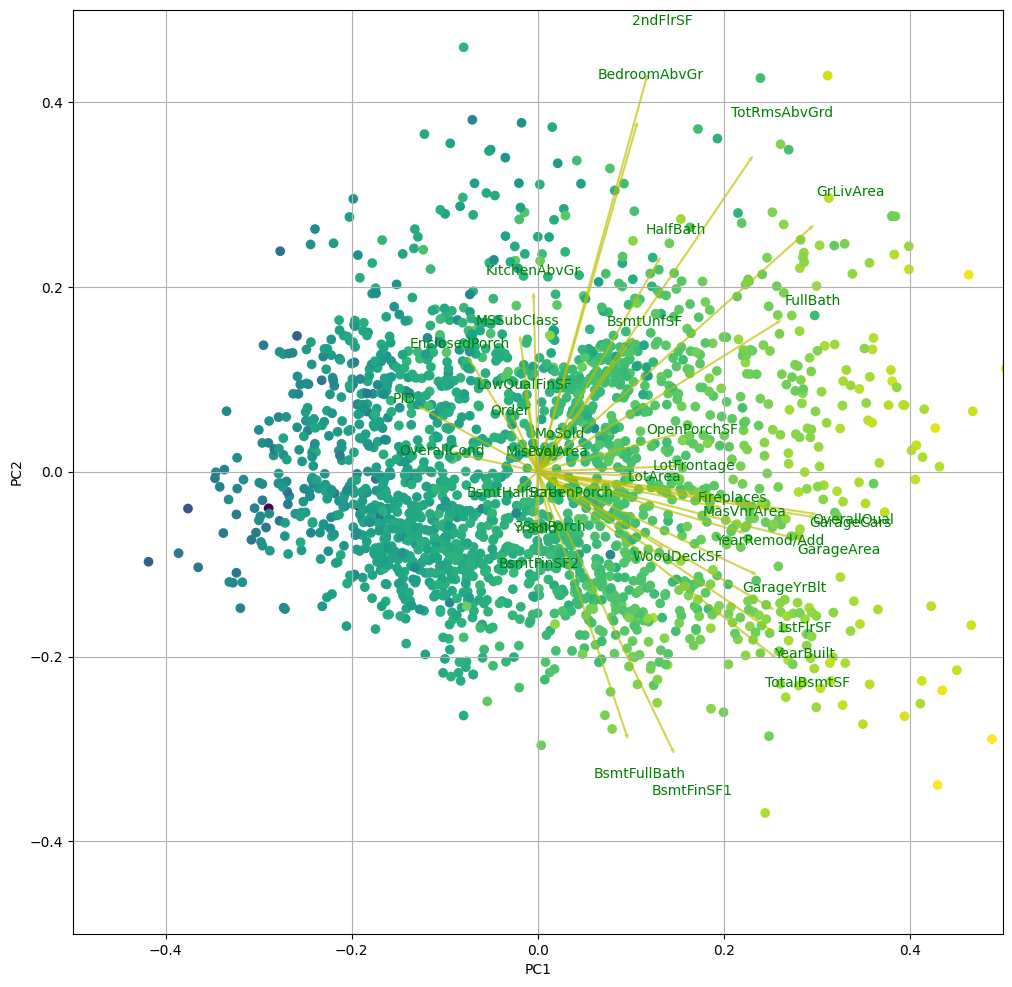

In [41]:
x_pca = preprocess_num_cols_3.fit_transform(X[num_cols])
plt.figure(figsize=(12, 12))
biplot(
    x_pca[:, :], np.transpose(pca_.components_[0:2, :]), labels=num_cols, plot_pc=(0, 1)
)

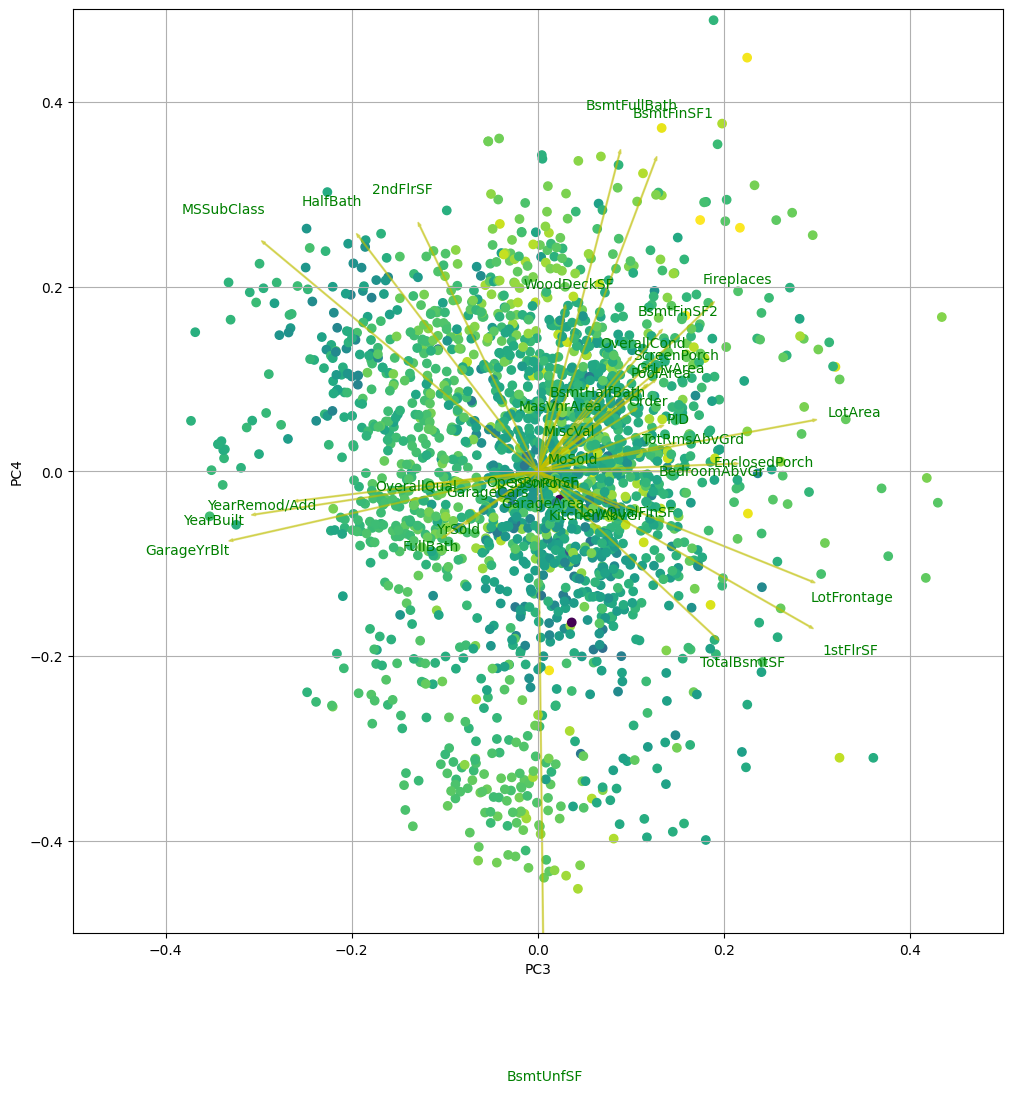

In [42]:
plt.figure(figsize=(12, 12))
biplot(
    x_pca[:, :], np.transpose(pca_.components_[2:4, :]), labels=num_cols, plot_pc=(2, 3)
)

### Does it help to use separate linear models?

Going back to `SaleCondition`, we are going to build 3 separate linear
models and see whether that gives a better result. Curious to see what
happens.

In [43]:
sale_condition_other = ["AdjLand", "Alloca", "Family", "missing"]
df.groupby("SaleCondition")["SalePrice"].describe().round(2)

/var/folders/0r/g9sj6_z95_70k7_pn0h5v0qc0000gn/T/ipykernel_38972/1610488576.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("SaleCondition")["SalePrice"].describe().round(2)


,count,mean,std,min,25%,50%,75%,max
SaleCondition,,,,,,,,
Abnorml,190.0,140396.25,80443.17,12789.0,98825.0,129450.0,159300.5,745000.0
AdjLand,12.0,108916.67,21988.46,81000.0,89500.0,110000.0,126375.0,150000.0
Alloca,24.0,161843.71,72213.54,50138.0,117574.0,149617.0,202043.0,359100.0
Family,46.0,157488.59,63376.52,79275.0,121025.0,144400.0,174000.0,409900.0
Normal,2413.0,175567.64,70979.61,35000.0,129500.0,159000.0,206900.0,755000.0
Partial,245.0,273374.37,100001.46,113000.0,195400.0,250000.0,336820.0,611657.0


In [44]:
from functools import partial

ols_cv = partial(
    cross_validate,
    cv=10,
    scoring=["neg_mean_squared_error"],
    return_train_score=True,
    return_estimator=True,
)
ols_models = {"Normal": {}, "Partial": {}, "Abnorml": {}, "Other": {}}

for condition in ols_models.keys():
    if condition != "Other":
        mask = X.SaleCondition == condition
    else:
        mask = X.SaleCondition.isin(sale_condition_other)
    ols_ = make_pipeline(prepare_linear, LinearRegression())
    ols_models[condition]["cv"] = ols_cv(ols_, X.loc[mask, :], y[mask])
    ols_best_index_ = np.argmax(
        np.sqrt(-ols_models[condition]["cv"]["train_neg_mean_squared_error"])
    )
    ols_models[condition]["estimator"] = ols_models[condition]["cv"]["estimator"][
        ols_best_index_
    ]

In [45]:
for condition, ols_score in ols_models.items():
    plot_cv_scores(ols_models[condition]["cv"]);

In [46]:
ols_rmsle = {}
for condition in ols_models.keys():
    if condition != "Other":
        mask = X_test.SaleCondition == condition
    else:
        mask = X_test.SaleCondition.isin(["AdjLand", "Alloca", "Familiy", "missing"])
    ols_rmsle[condition] = np.sqrt(
        mean_squared_error(
            y_test[mask],
            ols_models[condition]["estimator"].predict(X_test.loc[mask, :]),
        )
    )
ols_rmsle

{'Normal': 0.09143786442516227,
 'Partial': 0.5048447042954601,
 'Abnorml': 0.434674802342848,
 'Other': 0.30074708145489365}

In [52]:
# calculate weighted sum of squares of separate models
condition_counts = X_test.groupby("SaleCondition", observed=False)["SaleCondition"].count()
other_count = X_test[X_test["SaleCondition"].isin(sale_condition_other)].count().iloc[0]


total_ols_rmsle = np.sqrt(
    sum(
        [
            v**2 * condition_counts[k] if k != "Other" else v**2 * other_count
            for k, v in ols_rmsle.items()
        ]
    )
    / condition_counts.sum()
)
total_ols_rmsle

0.21738614729208197

So this isn’t really useful

In [48]:
# checking calculation weighted sum of squares
ols_msle = {k: v**2 for k, v in ols_rmsle.items()}
ols_msle

{'Normal': 0.008360883050634357,
 'Partial': 0.2548681754551706,
 'Abnorml': 0.18894218379179398,
 'Other': 0.09044880700363643}

In [49]:
np.sqrt(
    sum(
        {
            k: (v**2 * condition_counts[k] if k != "Other" else v**2 * other_count)
            for k, v in ols_rmsle.items()
        }.values()
    )
    / condition_counts.sum()
)

0.21738614729208197

## Concluding remarks

Hopefully this notebook has given you some clear pointers how to
structure your sklearn pipelines. The models we have developed performed
ok, with the validation scores somewhere between the 25% and 50%
percentile.

However, all test scores were significantly worse than validation
scores. This indicates we still haven’t tackled the overfitting and/or
randomness of local solutions in the model properly. It is left as an
exercise to further optimize you model to ensure your solutions are
stable and generalizable.